In [281]:

import sys
from pathlib import Path
from typing import Tuple

import joblib
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import time
import os
from tqdm import tqdm

# Optional deps used in helper/model stack
import torch  # noqa: F401
import cvxpy as cp  # noqa: F401

# neuromancer symbols are imported in notebook; here they are required indirectly via helper/models loading
from neuromancer.modules import blocks  # type: ignore
from neuromancer.system import Node, System  # type: ignore
from neuromancer.problem import Problem  # type: ignore
from neuromancer.loss import PenaltyLoss  # type: ignore

identification_path = Path.cwd().resolve().parent / 'Identification'
if str(identification_path) not in sys.path:
    sys.path.append(str(identification_path))
import baseline_inference  # type: ignore

In [282]:
baseline_inference.init()

Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs


In [283]:
# Resolve project paths (repo root assumed to be parent of this script's CWD)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

figures_dir = os.path.join(project_root, 'figures')
os.makedirs(figures_dir, exist_ok=True)

# Local imports from the project
import models  # type: ignore
import helper  # type: ignore

# -----------------------------
# Load matrices, model, scalers
# -----------------------------
matrix_C = False

A = np.load(f"../data/A_C_{matrix_C}.npy")
B = np.load(f"../data/B_C_{matrix_C}.npy")
C = np.load(f"../data/C_C_{matrix_C}.npy")



In [284]:
nz, nu = B.shape
ny = C.shape[0]

# disturbance matrix F and dimension nd
F = np.eye(ny)
nd = F.shape[1]

In [285]:



# Block-diagonalize A using helper
T_real, A_block = helper.ident.real_block_diagonalize(A)

# Transform A to check
A_transformed = inv(T_real) @ A @ T_real
print('Close to block diagonal?', np.allclose(A_block, A_transformed, atol=1e-6))

# Backtransform A_block to verify it equals A
A_backtransformed = T_real @ A_block @ inv(T_real)
print('Backtransformation equals original A?', np.allclose(A, A_backtransformed, atol=1e-6))

# Apply similarity transform to A, B, C
A = A_block
B = inv(T_real) @ B
C = C @ T_real

# -----------------------------
# Build Koopman model components
# -----------------------------
cons = 3
layers = [6*cons,12*cons,18*cons]
layers_dec  = [18*cons,12*cons,6*cons]

# Output encoder f_y
f_y = blocks.MLP(
    ny,
    nz,
    bias=True,
    linear_map=torch.nn.Linear,
    nonlin=torch.nn.ReLU,
    hsizes=layers,
)
encode_Y0 = Node(f_y, ['Y0'], ['x'], name='encoder_Y0')
encode_Y = Node(f_y, ['Y'], ['x_latent'], name='encoder_Y')

# Input encoder f_u representing B in linear system
f_u = torch.nn.Linear(nu, nz, bias=False)
encode_U = Node(f_u, ['U'], ['u_latent'], name='encoder_U')

# State decoder f_y_inv
if not matrix_C:
    f_y_inv = blocks.MLP(
        nz,
        ny,
        bias=True,
        linear_map=torch.nn.Linear,
        nonlin=torch.nn.ELU,
        hsizes=layers_dec,
    )
elif matrix_C:
    f_y_inv = torch.nn.Linear(nz, ny, bias=False)
else:
    raise ValueError('matrix_C must be boolean')

decode_y = Node(f_y_inv, ['x'], ['yhat'], name='decoder_y')

# Linear map K for latent dynamics
K = torch.nn.Linear(nz, nz, bias=False)

# Symbolic Koopman model with control inputs
Koopman = Node(helper.PredictionWControl(K), ['x', 'u_latent'], ['x'], name='K')
dynamics_model = System([Koopman], name='Koopman', nsteps=1)

nodes = [encode_Y0, encode_Y, encode_U, dynamics_model, decode_y]
loss = PenaltyLoss([], constraints=[])
problem = Problem(nodes, loss)


# -----------------------------
# Load scalers and plant model
# -----------------------------
scaler = joblib.load(os.path.join(project_root, 'data', 'scaler.pkl'))
scalerU = joblib.load(os.path.join(project_root, 'data', 'scalerU.pkl'))


Close to block diagonal? True
Backtransformation equals original A? True


In [286]:
problem.load_state_dict(
    torch.load(os.path.join(project_root, 'data', f'model_C_{matrix_C}.pth')),
    strict=True,
)

<All keys matched successfully>

In [287]:
# Check if matrix A is stable (all eigenvalues have modulus < 1)
eigenvalues = np.linalg.eigvals(A)
is_stable = np.all(np.abs(eigenvalues) < 1)
print("Is A stable?", is_stable)


Is A stable? True


In [288]:
def get_x(y: np.ndarray) -> np.ndarray:
    x = problem.nodes[0]({'Y0': torch.from_numpy(y).float()})
    return x['x'].detach().numpy().reshape(1, -1).T

def get_y(x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({'x': torch.from_numpy(x.T).float()})
    return y['yhat'].detach().numpy().reshape(1, -1)

def get_y_vector(x: np.ndarray) -> np.ndarray:
    y = problem.nodes[4]({'x': torch.from_numpy(x.T).float()})
    return y['yhat'].detach().numpy()
# -----------------------------
# Observer - Kalman filter setup
# -----------------------------
loaded_setup = joblib.load(os.path.join(os.getcwd(), 'sim_setup.pkl'))

y_start = loaded_setup['y_start']
y_start_ns = loaded_setup.get('y_start_ns')
reference_ns = loaded_setup.get('reference_ns')
y_setpoint = loaded_setup['reference'][:, 0]
u_previous = loaded_setup['u_previous']
u_previous_ns = loaded_setup.get('u_previous_ns')
u_sp = loaded_setup['reference_u']

# Initial state estimate includes disturbance
z_est_ = np.hstack(((inv(T_real) @ get_x(y_start)).T, np.zeros((1, nd))))
P0 = np.eye(nz + nd)*loaded_setup['P0']
Qd = np.eye(nd) * loaded_setup['Qd']
Q = np.block([
        [np.eye(nz) * loaded_setup['Q'],  np.zeros((nz, nd))],   # Trust state model
        [np.zeros((nd, nz)), Qd]      # Disturbance adapts slow
    ]) 
R = np.eye(ny)*loaded_setup['R']
Cd = np.eye(ny)
Bd = np.zeros((nz, nd))
# Cd = np.zeros((ny,nd))
# Bd = B

A_ = np.block([
    [A, Bd],
    [np.zeros((nd, nz)), np.eye(nd)],
])
B_ = np.vstack([
    B,
    np.zeros((nd, nu)),
])

C_ = np.hstack([
    C, Cd,
])

TVKF = helper.TVKF(A_, B_, C_, z_est_, P0, Q, R)
# EKF = helper.EKF_C(A_, B_, C, z_est_, P0, problem, Q, Rm, 2, T_real)

# -----------------------------
# Target calculation
# -----------------------------
target_estimation = helper.TaylorTargetEstimation(A, B, loaded_setup["Qy_te"], loaded_setup["Qu_te"], Bd, Cd)
target_energy = helper.TaylorTargetEnergyEstimation(A, B, loaded_setup["Qe_te"], Bd, Cd)

J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real @ z_est_[0, :nz]).float(),
) @ T_real

z_s, y_s, u_s = target_estimation.get_target(
    z_est_[:, nz:], y_setpoint, u_sp, get_y(T_real @ z_est_[0, :nz]), z_est_[0, :nz], J
)
z_s_energy, y_s_energy, u_s_energy = target_energy.get_target(
    z_est_[:, nz:], y_s, u_s, get_y(T_real @ z_est_[0, :nz]), z_est_[0, :nz], J
)


print(target_estimation.te.status)
print('Optimal y:', scaler.inverse_transform(y_s.reshape(1, -1)))
print('Desired y:', scaler.inverse_transform(y_setpoint.reshape(1, -1)))
print('Optimal u:', scalerU.inverse_transform(target_estimation.u_s.value.reshape(1, -1)))
print('Optimal y:', scaler.inverse_transform(y_s_energy.reshape(1, -1)))
print('Desired y:', scaler.inverse_transform(y_setpoint.reshape(1, -1)))
print('Optimal u:', scalerU.inverse_transform(target_energy.u_s.value.reshape(1, -1)))
z_ref = z_s_energy


optimal
Optimal y: [[58.         68.84056355 60.0601879 ]]
Desired y: [[58.       74.440544 61.206383]]
Optimal u: [[50.00000013 57.14348479 17.37955263]]
Optimal y: [[58.         64.0616179  61.29702002]]
Desired y: [[58.       74.440544 61.206383]]
Optimal u: [[ 50.00000013 100.          15.31409934]]


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


In [289]:

# -----------------------------
# MPC problem formulation
# -----------------------------
Qy = loaded_setup['Qy']
J = helper.evaluate_jacobian(
    problem.nodes[4],
    torch.from_numpy(T_real @ z_s).float(),
) @ T_real
Qz = J.T @ Qy @ J
Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])

mpc = helper.TaylorMPC(A, B, loaded_setup["Qy"], loaded_setup["Qu"], loaded_setup["Qdu"], Bd, Cd)
mpc.build_problem()
u_opt = mpc.get_u_optimal(
    z_est_[0, :nz], z_est_[:, nz:], u_previous, z_ref, u_s, get_y(T_real @ z_s), z_s, J, Qz_psd
)
print(u_opt)
print(mpc.mpc.status)


/Users/patrik/miniconda3/envs/kmpc/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:245: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Disciplined Parametrized Programming, at https://www.cvxpy.org/tutorial/dpp/index.html
  warnings.warn(DPP_ERROR_MSG)


[-0.34875115  1.4082766  -0.38903676]
optimal


In [290]:
baseline_inference.get_x(y_start)

In [291]:

# -----------------------------
# Closed-loop simulation
# -----------------------------
sim_time = loaded_setup['sim_time']
Ts = 1
z_sim = np.zeros((nz + nd, sim_time + 1))
y_sim = np.zeros((ny, sim_time + 1))
y_pred = np.zeros((ny, sim_time + 1))
u_sim = np.zeros((nu, sim_time))
us_sim = np.zeros((nu, sim_time + 1))
ys_sim = np.zeros((ny, sim_time + 1))
zs_sim = np.zeros((nz, sim_time + 1))
us_sim_energy = np.zeros((nu, sim_time + 1))
ys_sim_energy = np.zeros((ny, sim_time + 1))
zs_sim_energy = np.zeros((nz, sim_time + 1))

total_time_target = 0.0
total_time_mpc = 0.0

start_time_target = time.time()
z_s, y_s, u_s = target_estimation.get_target(
    z_est_[:, nz:], y_setpoint, u_sp, get_y(T_real @ z_s), z_s, J
)
z_s_energy, y_s_energy, u_s_energy = target_energy.get_target(
    z_est_[:, nz:], y_s, u_s, get_y(T_real @ z_s), z_s, J
)
end_time_target = time.time()
total_time_target += end_time_target - start_time_target

y_sim_descaled = np.zeros((ny, sim_time + 1))
u_sim_descaled = np.zeros((nu, sim_time))

z_sim[:, 0] = z_est_.flatten()
y_sim[:, 0] = y_start.flatten()
ys_sim[:, 0] = y_s
zs_sim[:, 0] = z_s
ys_sim_energy[:, 0] = y_s_energy
zs_sim_energy[:, 0] = z_s_energy
us_sim_energy[:, 0] = u_s_energy
u_prev = target_estimation.u_s.value
u_sim_descaled[:, 0] = scalerU.inverse_transform(u_sim[:, 0].reshape(1, -1))[0]
y_sim_descaled[:, 0] = scaler.inverse_transform(y_sim[:, 0].reshape(1, -1))[0]

J = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(T_real @ zs_sim_energy[:, 0]).float(),
    ) @ T_real

from tqdm import trange
for k in trange(sim_time):
    y_setpoint = loaded_setup['reference'][:, k]
    idx_prev = max(k - 1, 0)

    # target update (T2): linearize at previous target zs_sim[:, k]
    # J = helper.evaluate_jacobian(
    #     problem.nodes[4],
    #     torch.from_numpy(T_real @ zs_sim_energy[:, idx_prev]).float(),
    # ) @ T_real
    start_time_target = time.time()
    zs_sim[:, k], ys_sim[:, k], us_sim[:, k] = target_estimation.get_target(
        z_sim[nz:, k], 
        y_setpoint, 
        u_sp,
        get_y(T_real @ zs_sim_energy[:, idx_prev]), 
        zs_sim_energy[:, idx_prev], 
        J
    )

    zs_sim_energy[:, k], ys_sim_energy[:, k], us_sim_energy[:, k] = target_energy.get_target(
        z_sim[nz:, k], 
        ys_sim[:, k], 
        us_sim[:, k],
        get_y(T_real @ zs_sim_energy[:, idx_prev]), 
        zs_sim_energy[:, idx_prev], 
        J
    )

    y_pred[:,k] = J@z_sim[:nz,k] + get_y(T_real @ zs_sim[:, idx_prev]) - J @ zs_sim[:, idx_prev]
    end_time_target = time.time()
    total_time_target += end_time_target - start_time_target

    # T2/D2: for MPC, linearize at the previous target zs_sim[:, k-1] (use k=0 fallback)
    # J_prev = helper.evaluate_jacobian(
    #     problem.nodes[4],
    #     torch.from_numpy(T_real @ zs_sim[:, idx_prev]).float(),
    # ) @ T_real
    # J = J_prev

    # if k > 0:
    Qz = J.T @ Qy @ J
    Qz_psd = Qz + 1e-8 * np.eye(Qz.shape[0])
    # mpc.build_problem(Qz_psd)

    start_time_mpc = time.time()
    u_opt = mpc.get_u_optimal(
        z_sim[:nz, k],
        z_sim[nz:, k],
        u_prev,
        zs_sim_energy[:, k],
        us_sim_energy[:, k],
        get_y(T_real @ zs_sim_energy[:, idx_prev]),
        zs_sim_energy[:, idx_prev],
        J,
        Qz_psd
    )

    end_time_mpc = time.time()
    total_time_mpc += end_time_mpc - start_time_mpc

    u_sim[:, k] = u_opt
    u_sim_descaled[:, k] = scalerU.inverse_transform(u_sim[:, k].reshape(1, -1))[0]

    # simulate plant in physical space
    # for i in range(int(10-1)):
    #     baseline_inference.y_plus(u_sim[:, k])
    y_sim[:, k + 1] = baseline_inference.y_plus(u_sim[:, k])
    noise_std = 0.01  # You can adjust this value as desired
    noise = np.random.normal(0, noise_std, size=y_sim[:, k + 1].shape)
    y_sim[:, k + 1] += noise
    y_sim_descaled[:, k + 1] = scaler.inverse_transform(y_sim[:, k + 1].reshape(1, -1))[0]

    

    #compute before state estm. hold until next KF step
    J = helper.evaluate_jacobian(
        problem.nodes[4],
        torch.from_numpy(T_real @ zs_sim_energy[:, k]).float(),
    ) @ T_real
    
    C_ = np.hstack([
        J, Cd,
    ])

    # state estimation
    z_sim[:, k + 1] = TVKF.step(
        u_sim[:, k], 
        y_sim[:, k + 1],
        get_y(T_real @ zs_sim_energy[:nz, k]), 
        zs_sim_energy[:nz, k], 
        J,
        C_
        ).flatten()

    u_prev = u_sim[:, k]

print(f'Total time spent in target estimation: {total_time_target:.4f} seconds')
print(f'Total time spent in MPC solve: {total_time_mpc:.4f} seconds')


  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:20<00:00,  3.56it/s]

Total time spent in target estimation: 4.9274 seconds
Total time spent in MPC solve: 134.5881 seconds


In [292]:
target_estimation.Qy

array([[5., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [293]:
y_setpoint

array([0.53395489, 0.56853202, 0.56786697])

Closed-loop objective function value: 4182.2935110161925
  - State tracking term: 3863.55562187686
  - Input increment term: 206.5614488641192
  - Input setpoint term: 112.17644027521287


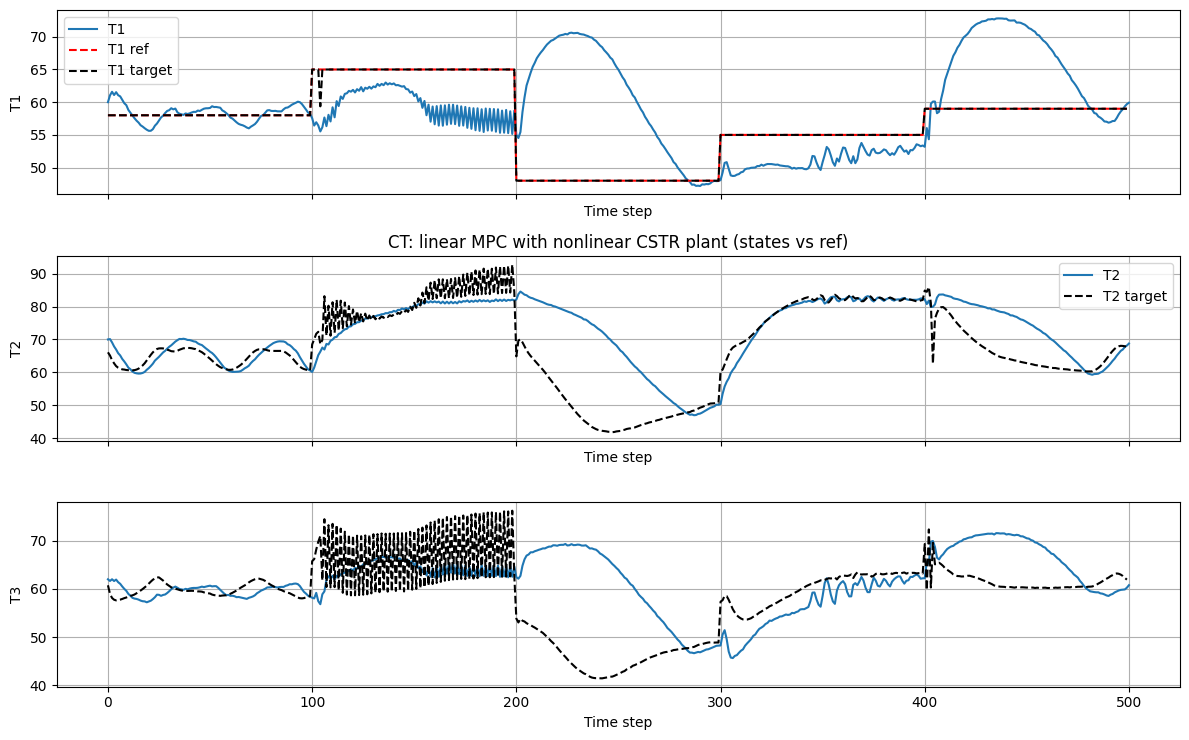

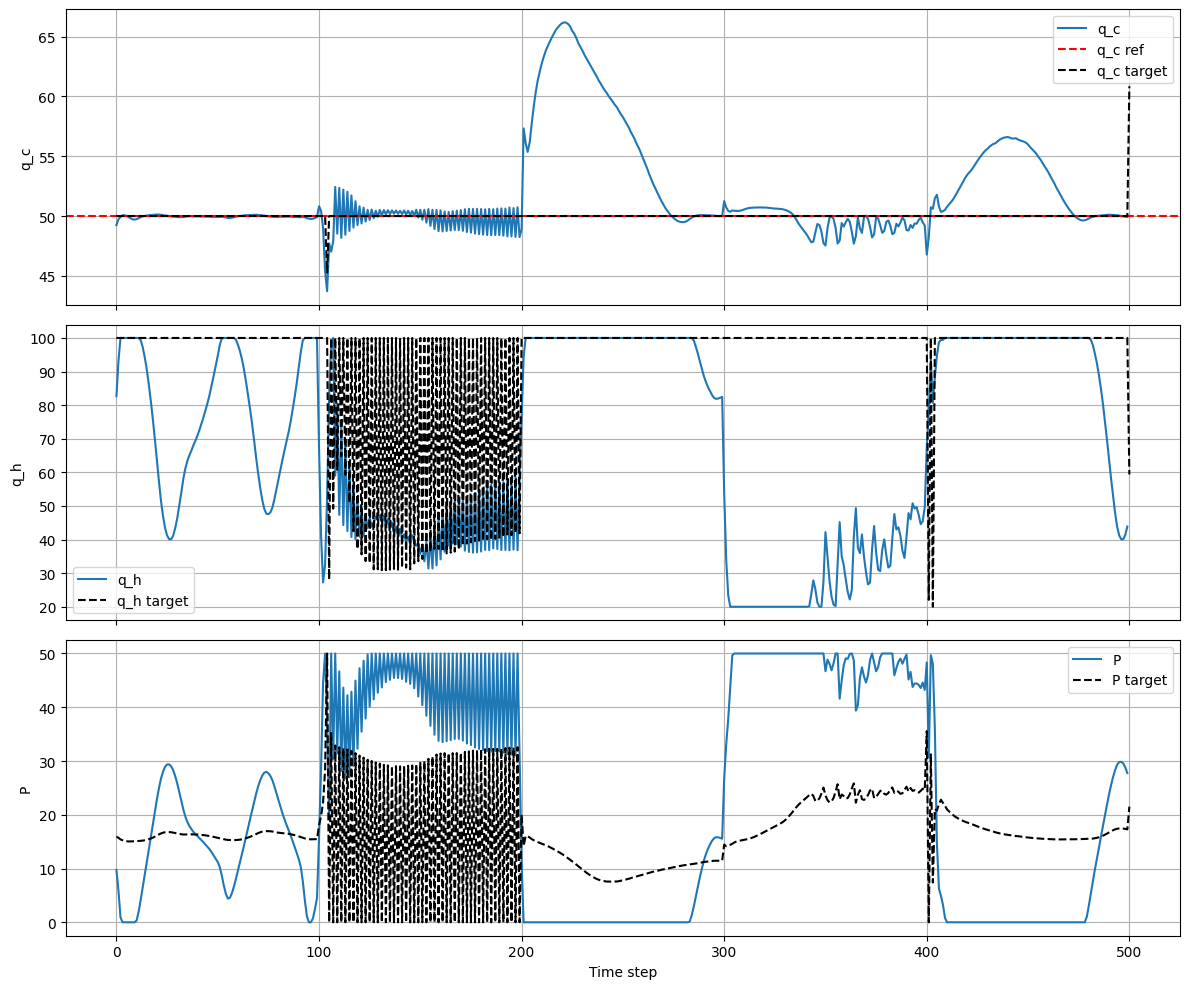

In [294]:
reference = loaded_setup['reference']
# Compute objective in non-scaled units (like NMPC.py)
Qu = loaded_setup['Qu']
Qy = loaded_setup['Qy']
Qdu = loaded_setup['Qdu']
objective_value = 0.0
state_error_cost = 0.0
control_increment_cost = 0.0
control_setpoint_cost = 0.0
for k in range(sim_time):
    y_ref_k = ys_sim_energy[:, k]
    y_diff = y_sim[:, k] - y_ref_k
    prev_u = u_sim[:, k - 1] if k > 0 else u_sim[:, k]
    u_diff = u_sim[:, k] - prev_u
    u_error = us_sim_energy[:, k] - u_sim[:, k]
    y_term = float(y_diff.T @ Qy @ y_diff)
    u_term = float(u_diff.T @ Qdu @ u_diff)
    u_sp_term = float(u_error.T @ Qu @ u_error)
    state_error_cost += y_term
    control_increment_cost += u_term
    control_setpoint_cost += u_sp_term
    objective_value += y_term + u_term + u_sp_term

print(f"Closed-loop objective function value: {objective_value}")
print(f"  - State tracking term: {state_error_cost}")
print(f"  - Input increment term: {control_increment_cost}")
print(f"  - Input setpoint term: {control_setpoint_cost}")



names = ['T1', 'T2', 'T3']
n_steps = sim_time
ys_sim_ns = scaler.inverse_transform(ys_sim_energy.T).T
us_sim_ns = scalerU.inverse_transform(us_sim_energy.T).T
y_pred_ns = scaler.inverse_transform(y_pred.T).T

fig, axs = plt.subplots(min(8, ny), 1, figsize=(12, 2.5*min(8, ny)), sharex=True)
if min(8, ny) == 1:
    axs = [axs]  # ensure axs is iterable even for 1 plot

for i in range(min(8, ny)):
    ax = axs[i]
    ax.plot(y_sim_descaled[i, :], label=names[i] if i < len(names) else f'y{i}')
    if i==0:
        ax.plot(reference_ns[i, :n_steps+1], 'r--', label=f'{names[i]} ref' if i < len(names) else f'y{i} ref')
    ax.plot(ys_sim_ns[i, :n_steps], 'k--', label=f'{names[i]} target')
    # ax.plot(y_pred_ns[i, :n_steps], 'g--', label=f'{names[i]} pred')
    ax.set_xlabel('Time step')
    ax.set_ylabel(names[i] if i < len(names) else f'y{i}')
    ax.grid(True)
    if i in (0, 1):
        ax.legend()
    if i == 1:
        ax.set_title('CT: linear MPC with nonlinear CSTR plant (states vs ref)')
plt.tight_layout()


fig_inputs, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
input_names = ['q_c', 'q_h', 'P']
for i in range(3):
    axs[i].plot(u_sim_descaled[i, :], label=input_names[i])
    if i==0:
        axs[i].axhline(50, color='red', linestyle='--', label=f"{input_names[i]} ref")
    axs[i].plot(us_sim_ns[i, :], 'k--', label=f"{input_names[i]} target")
    axs[i].set_ylabel(input_names[i])
    axs[i].grid(True)
    axs[i].legend()
axs[-1].set_xlabel('Time step')
fig_inputs.tight_layout()
#538

In [295]:
mpc.Qu

array([[5., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [296]:
loaded_setup['Qd']

0.1

In [297]:
sum(sum(z_sim[nz:,:]))

np.float64(-444.8209034922213)

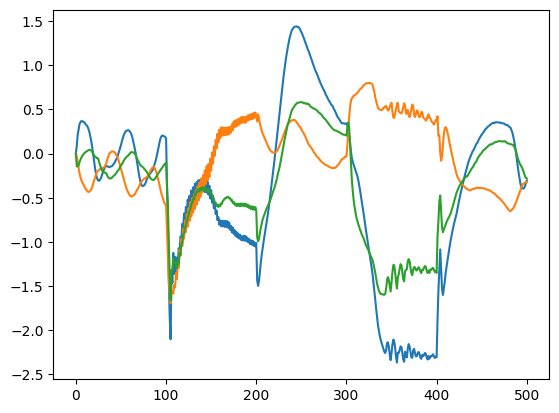

In [298]:
plt.plot(z_sim[nz:,:].T)

In [299]:
z_sim[nz:,-1]

array([-0.30570276, -0.32275233, -0.28093943])

In [300]:
ys_sim_ns[:,-2]

array([59.        , 67.69517524, 61.92692545])

## Fast Test: Observer Open-Loop with Constant Bias

Test the observer's ability to track a constant bias in open-loop (or with fixed stabilizing control).

FAST TEST: Observer Open-Loop with Constant Bias

Calculating true bias from steady-state mismatch...
  Finding baseline plant steady state (u=0)...
Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs
  Baseline steady state (u=0): [0.70396197 0.5471474  0.49608237]
  Finding Koopman model steady state (u=0)...
  Koopman steady state (u=0):  [0. 0. 0.]

  TRUE BIAS (model mismatch): [0.70396197 0.54714739 0.49608237]

Initial conditions:
  Koopman state from main sim: [-0.36509861 -0.03632145  0.28247328]...
  True bias: [0.70396197 0.54714739 0.49608237]
  Fixed control input: [0. 0. 0.]

Running 200 steps...

RESULTS:

Final bias estimation (last time step):
  Output 1: True=+0.7040, Est=+0.6178, Error=0.0862
  Output 2: True=+0.5471, Est=+0.4527, Error=0.0944
  Output 3: True=+0.4961, Est=+0.4289, Error=0.0672

Mean error over last 50 steps:
  Output 1: 0.1181
  Output 2: 0.1307
  Output 3: 0.0919


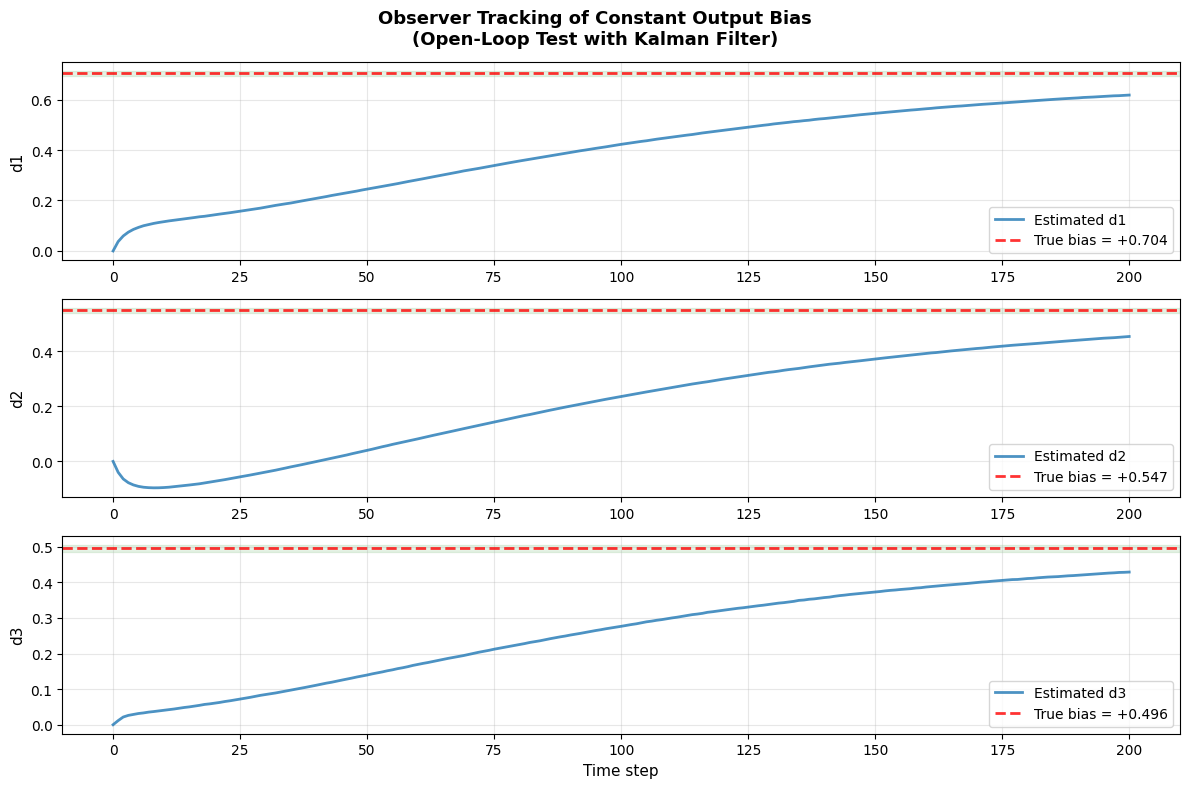


Test completed successfully!


In [301]:
# Fast test: Observer tracking constant bias
print("="*60)
print("FAST TEST: Observer Open-Loop with Constant Bias")
print("="*60)

# ==============================================================================
# Calculate TRUE bias: steady-state mismatch between baseline and Koopman
# ==============================================================================
print("\nCalculating true bias from steady-state mismatch...")

# Zero input
u_zero = np.zeros(nu)

# Baseline plant: find steady-state output with zero input
print("  Finding baseline plant steady state (u=0)...")
baseline_inference.init()  # Reset baseline
n_ss_steps = 500  # Steps to reach steady state
for _ in range(n_ss_steps):
    y_baseline_ss = baseline_inference.y_plus(u_zero)

print(f"  Baseline steady state (u=0): {y_baseline_ss}")

# Koopman model: steady-state with zero input
print("  Finding Koopman model steady state (u=0)...")
z_koopman_ss = np.zeros(nz)
for _ in range(n_ss_steps):
    z_koopman_ss = A @ z_koopman_ss + B @ u_zero
y_koopman_ss = C @ z_koopman_ss

print(f"  Koopman steady state (u=0):  {y_koopman_ss}")

# TRUE BIAS = baseline output - Koopman output (at zero input steady state)
true_bias = y_baseline_ss - y_koopman_ss

print(f"\n  TRUE BIAS (model mismatch): {true_bias}")
print("="*60)

# Setup scenario
N_test = 200  # Test horizon

# Initialize states for the augmented system (Koopman states + disturbance estimate)
z_test = np.zeros((nz + nd, N_test+1))
y_test = np.zeros((ny, N_test+1))

# Initial condition - start from the final state of the main simulation
z_test[:nz, 0] = z_sim[:nz, -1]  # Use final Koopman state from main simulation
z_test[nz:, 0] = np.zeros(nd)    # Start with zero disturbance estimate

# Initial output with bias
y_test[:, 0] = C @ z_test[:nz, 0] + true_bias

# Fixed control at steady state
u_fixed = us_sim[:, -1].reshape(-1, 1)  # Use final control from main simulation

# Create a simple Kalman filter for this test
# Using the same Q and R from the main simulation
P_test = P0.copy()
TVKF_test = helper.TVKF(A_, B_, C_, z_test[:, [0]].T, P_test, Q, R)

print(f"\nInitial conditions:")
print(f"  Koopman state from main sim: {z_test[:nz, 0][:3]}...")  # Show first 3 elements
print(f"  True bias: {true_bias}")
print(f"  Fixed control input: {u_fixed.flatten()}")
print(f"\nRunning {N_test} steps...")

# Simulate the system
for k in range(N_test):
    # True system evolution: use the Koopman model as the "true" system
    # In practice, you could also use baseline_inference.y_plus(u_fixed) for the physical plant
    z_true = A @ z_test[:nz, k] + B @ u_fixed.flatten()
    y_test[:, k+1] = C @ z_true + true_bias  # Add constant bias to output
    
    # Small measurement noise
    noise_std = 0.001
    noise = np.random.normal(0, noise_std, size=ny)
    y_test[:, k+1] += noise
    
    # Observer update using the Kalman filter
    # Note: C_ needs to be constant here since we're using fixed linearization
    C_test = np.hstack([C, Cd])
    
    z_test[:, k+1] = TVKF_test.step(
        u_fixed.flatten(),
        y_test[:, k+1],
        C @ z_test[:nz, k],  # Linearization point output
        z_test[:nz, k],      # Linearization point state
        C,                    # Jacobian (constant for linear Koopman)
        C_test
    ).flatten()

# Extract estimated disturbance
d_est_test = z_test[nz:, :]

# Calculate convergence metrics
final_error = np.abs(true_bias - d_est_test[:, -1])
mean_error_last_50 = np.mean(np.abs(true_bias[:, np.newaxis] - d_est_test[:, -50:]), axis=1)

print(f"\n" + "="*60)
print("RESULTS:")
print("="*60)
print("\nFinal bias estimation (last time step):")
for i in range(ny):
    print(f"  Output {i+1}: True={true_bias[i]:+.4f}, Est={d_est_test[i, -1]:+.4f}, Error={final_error[i]:.4f}")

print(f"\nMean error over last 50 steps:")
for i in range(ny):
    print(f"  Output {i+1}: {mean_error_last_50[i]:.4f}")

# Plot results
fig, axes = plt.subplots(ny, 1, figsize=(12, 8))
if ny == 1:
    axes = [axes]

for i in range(ny):
    axes[i].plot(d_est_test[i, :], label=f'Estimated d{i+1}', linewidth=2, alpha=0.8)
    axes[i].axhline(y=true_bias[i], color='r', linestyle='--', linewidth=2, 
                    label=f'True bias = {true_bias[i]:+.3f}', alpha=0.8)
    axes[i].set_ylabel(f'd{i+1}', fontsize=11)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)
    
    # Add shaded region showing final convergence zone
    axes[i].axhspan(true_bias[i] - 0.01, true_bias[i] + 0.01, 
                    alpha=0.1, color='green', label='±0.01 tolerance')

axes[-1].set_xlabel('Time step', fontsize=11)
fig.suptitle('Observer Tracking of Constant Output Bias\n(Open-Loop Test with Kalman Filter)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("Test completed successfully!")

## Fast Test 2: Observer with Constant Input to Baseline Plant

Test the observer against the true physical plant (baseline_inference) with constant control input.

FAST TEST 2: Observer with Constant Input to Baseline Plant

Calculating true disturbance from steady-state mismatch...
  Finding baseline plant steady state (u=0)...
Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs
  Baseline steady state (u=0): [0.70514685 0.548638   0.49703395]
  Finding Koopman model steady state (u=0)...
  Koopman steady state (u=0):  [0. 0. 0.]

  TRUE DISTURBANCE (model mismatch): [0.70514685 0.54863799 0.49703395]
Model initialized successfully!
A matrix shape: (35, 35)
B matrix shape: (35, 3)
Scalers loaded for 3 outputs and 3 inputs

Test setup:
  Initial Koopman state: [-0.00949745 -0.01731815 -0.02327549]...
  Initial output: [0.70514768 0.54863894 0.49703461]
  Constant control input: [0. 0. 0.]

Running 2000 steps with baseline plant...

RESULTS:

True disturbance (steady-state model mismatch):
  [0.70514685 0.54863799 0.49703395]

Final disturbance estimation (last time step):
  Ou

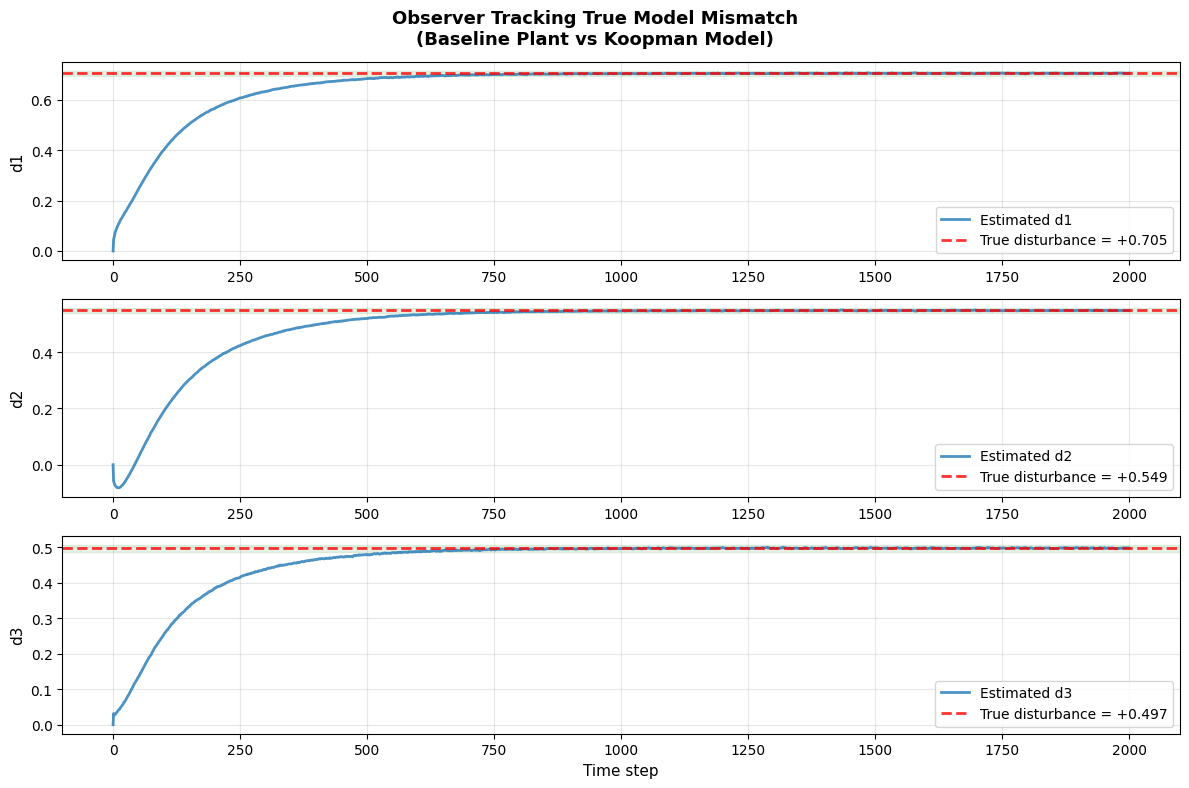


Output comparison (Baseline Plant vs Koopman Prediction):
Baseline plant output:      [0.70753339 0.54867654 0.49568819]
Koopman + est. disturbance: [0.70649453 0.54866137 0.49703946]
Prediction error:           [1.03886069e-03 1.51696471e-05 1.35127643e-03]

Estimated disturbance converged to: [0.70555943 0.54829425 0.49711767]
True steady-state mismatch:         [0.70514685 0.54863799 0.49703395]

Test completed successfully!


In [302]:
# Fast test 2: Observer with constant input to baseline plant
print("="*60)
print("FAST TEST 2: Observer with Constant Input to Baseline Plant")
print("="*60)

# ==============================================================================
# Calculate TRUE disturbance: steady-state mismatch between baseline and Koopman
# ==============================================================================
print("\nCalculating true disturbance from steady-state mismatch...")

# Zero input
u_zero = np.zeros(nu)

# Baseline plant: find steady-state output with zero input
# Run baseline for many steps to reach steady state
print("  Finding baseline plant steady state (u=0)...")
baseline_inference.init()  # Reset baseline
n_ss_steps = 500  # Steps to reach steady state
for _ in range(n_ss_steps):
    y_baseline_ss = baseline_inference.y_plus(u_zero)

print(f"  Baseline steady state (u=0): {y_baseline_ss}")

# Koopman model: steady-state with zero input
# For a stable linear system, steady state is when z[k+1] = z[k]
# So: z_ss = A @ z_ss + B @ u  =>  (I - A) @ z_ss = B @ u
# With u=0: (I - A) @ z_ss = 0  =>  z_ss = 0 (if A is stable and has no integrators)
# But we can also just simulate it
print("  Finding Koopman model steady state (u=0)...")
z_koopman_ss = np.zeros(nz)
for _ in range(n_ss_steps):
    z_koopman_ss = A @ z_koopman_ss + B @ u_zero
y_koopman_ss = C @ z_koopman_ss

print(f"  Koopman steady state (u=0):  {y_koopman_ss}")

# TRUE DISTURBANCE = baseline output - Koopman output (at zero input steady state)
true_disturbance = y_baseline_ss - y_koopman_ss

print(f"\n  TRUE DISTURBANCE (model mismatch): {true_disturbance}")
print("="*60)

# ==============================================================================
# Run test with constant (non-zero) input
# ==============================================================================
N_test2 = 2000  # Test horizon

# Initialize observer states
z_test2 = np.zeros((nz + nd, N_test2+1))
y_test2 = np.zeros((ny, N_test2+1))

# Start from a known state
# Re-initialize baseline to match a specific state
baseline_inference.init()
# Set initial state by applying the final control from main simulation a few times
for _ in range(10):
    y_init = baseline_inference.y_plus(us_sim[:, -1])

# Initial Koopman state corresponding to this output
z_test2[:nz, 0] = get_x(y_init).flatten()  # Get Koopman state from output
z_test2[nz:, 0] = np.zeros(nd)    # Start with zero disturbance estimate

y_test2[:, 0] = y_init

# Constant control input (use steady-state control from main simulation)
u_const = us_sim[:, -1].copy()

# Create Kalman filter for this test
P_test2 = P0.copy()
TVKF_test2 = helper.TVKF(A_, B_, C_, z_test2[:, [0]].T, P_test2, Q, R)

print(f"\nTest setup:")
print(f"  Initial Koopman state: {z_test2[:nz, 0][:3]}...")
print(f"  Initial output: {y_test2[:, 0]}")
print(f"  Constant control input: {u_const}")
print(f"\nRunning {N_test2} steps with baseline plant...")

# Simulate with baseline plant
for k in range(N_test2):
    # Step the TRUE physical plant (baseline_inference)
    y_plant = baseline_inference.y_plus(u_const)
    
    # The plant already has the inherent model mismatch (true_disturbance)
    # No need to add it - it's already there!
    y_test2[:, k+1] = y_plant
    
    # Add small measurement noise
    noise_std = 0.002
    noise = np.random.normal(0, noise_std, size=ny)
    y_test2[:, k+1] += noise
    
    # Observer prediction and correction using Kalman filter
    C_test2 = np.hstack([C, Cd])
    
    z_test2[:, k+1] = TVKF_test2.step(
        u_const,
        y_test2[:, k+1],
        C @ z_test2[:nz, k],  # Linearization point output
        z_test2[:nz, k],       # Linearization point state
        C,                      # Jacobian
        C_test2
    ).flatten()

# Extract estimated disturbance
d_est_test2 = z_test2[nz:, :]

# Calculate convergence metrics
# NOTE: The true disturbance might differ from steady-state mismatch during transients
# but should converge to it at steady state
final_error2 = np.abs(true_disturbance - d_est_test2[:, -1])
mean_error_last_50_2 = np.mean(np.abs(true_disturbance[:, np.newaxis] - d_est_test2[:, -50:]), axis=1)

print(f"\n" + "="*60)
print("RESULTS:")
print("="*60)
print("\nTrue disturbance (steady-state model mismatch):")
print(f"  {true_disturbance}")

print("\nFinal disturbance estimation (last time step):")
for i in range(ny):
    print(f"  Output {i+1}: True={true_disturbance[i]:+.4f}, Est={d_est_test2[i, -1]:+.4f}, Error={final_error2[i]:.4f}")

print(f"\nMean error over last 50 steps:")
for i in range(ny):
    print(f"  Output {i+1}: {mean_error_last_50_2[i]:.4f}")

# Plot results
fig, axes = plt.subplots(ny, 1, figsize=(12, 8))
if ny == 1:
    axes = [axes]

for i in range(ny):
    axes[i].plot(d_est_test2[i, :], label=f'Estimated d{i+1}', linewidth=2, alpha=0.8)
    axes[i].axhline(y=true_disturbance[i], color='r', linestyle='--', linewidth=2, 
                    label=f'True disturbance = {true_disturbance[i]:+.3f}', alpha=0.8)
    axes[i].set_ylabel(f'd{i+1}', fontsize=11)
    axes[i].legend(loc='best')
    axes[i].grid(True, alpha=0.3)
    
    # Add shaded convergence zone
    axes[i].axhspan(true_disturbance[i] - 0.01, true_disturbance[i] + 0.01, 
                    alpha=0.1, color='green')

axes[-1].set_xlabel('Time step', fontsize=11)
fig.suptitle('Observer Tracking True Model Mismatch\n(Baseline Plant vs Koopman Model)', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

# Compare outputs: baseline plant vs Koopman model prediction
print("\n" + "="*60)
print("Output comparison (Baseline Plant vs Koopman Prediction):")
print("="*60)
y_koopman_pred = C @ z_test2[:nz, -1] + d_est_test2[:, -1]
y_baseline_actual = y_test2[:, -1]
print(f"Baseline plant output:      {y_baseline_actual}")
print(f"Koopman + est. disturbance: {y_koopman_pred}")
print(f"Prediction error:           {np.abs(y_baseline_actual - y_koopman_pred)}")
print(f"\nEstimated disturbance converged to: {d_est_test2[:, -1]}")
print(f"True steady-state mismatch:         {true_disturbance}")

print("\n" + "="*60)
print("Test completed successfully!")